In [ ]:
import yfinance as yf
import pandas as pd
import plotly.express as px

# Define the tickers
tickers = {
    'Bitcoin': 'btc-USD',
}

""" tickers = {
    'SPY': 'SPY',        # SPDR S&P 500 ETF Trust
    'Apple': 'AAPL',     # Apple Inc.
    'NVIDIA': 'NVDA',    # NVIDIA Corporation
    'Tesla': 'TSLA',     # Tesla Inc.
    'Bitcoin': 'btc-USD', # Bitcoin
    # Additional popular tickers
    'Amazon': 'AMZN',    # Amazon.com, Inc.
    'Google': 'GOOGL',   # Alphabet Inc. (Class A)
    'Microsoft': 'MSFT', # Microsoft Corporation
    'Meta': 'META',      # Meta Platforms, Inc.
} """

# Download historical data for the tickers
data = yf.download(
    tickers=list(tickers.values()),
    period='5y',       # Adjust the period as needed # Adjust the period as needed '6mo' '1d' 'max'
    interval='1d',     # Data interval Data interval '1m' '1h' '1d'       #best is w max and 1d so far
    group_by='ticker',
    auto_adjust=True,
    threads=True
)

print(data)

btc = data

#Flattening the multi-level columns
btc.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in btc.columns]
ticker_prefix = btc.columns[0].split('_')[0]

# Renaming the columns to remove prefixes and simplify names
new_column_names = {
    f'{ticker_prefix}_Open': 'Open',
    f'{ticker_prefix}_High': 'High',
    f'{ticker_prefix}_Low': 'Low',
    f'{ticker_prefix}_Close': 'Close',
    f'{ticker_prefix}_Volume': 'Volume'
}
btc.rename(columns=new_column_names, inplace=True)

# Reset the index, which moves the date from the index to a column
btc.reset_index(inplace=True)

print(btc)

# Step 1: Extract Bitcoin Volume before dropping columns
print(btc['Volume'].eq(0).sum())
print(btc)
print(btc.describe())
na_counts = btc.isna().sum()

# Display the count of NaNs for each column
print(na_counts)


[*********************100%***********************]  1 of 1 completed

Ticker                           BTC-USD                               \
Price                               Open           High           Low   
Date                                                                    
2019-12-10 00:00:00+00:00    7397.134277    7424.022949   7246.043945   
2019-12-11 00:00:00+00:00    7277.197754    7324.156250   7195.527344   
2019-12-12 00:00:00+00:00    7216.738770    7266.639648   7164.741211   
2019-12-13 00:00:00+00:00    7244.662109    7293.560547   7227.122559   
2019-12-14 00:00:00+00:00    7268.902832    7308.836426   7097.208984   
...                                  ...            ...           ...   
2024-12-06 00:00:00+00:00   97074.226562  102039.882812  96514.875000   
2024-12-07 00:00:00+00:00   99916.710938  100563.382812  99030.882812   
2024-12-08 00:00:00+00:00   99921.914062  101399.992188  98771.515625   
2024-12-09 00:00:00+00:00  101237.062500  101272.507812  94355.914062   
2024-12-10 00:00:00+00:00   97391.328125   98220.03

                          Date           Open           High           Low  \
0    2019-12-10 00:00:00+00:00    7397.134277    7424.022949   7246.043945   
1    2019-12-11 00:00:00+00:00    7277.197754    7324.156250   7195.527344   
2    2019-12-12 00:00:00+00:00    7216.738770    7266.639648   7164.741211   
3    2019-12-13 00:00:00+00:00    7244.662109    7293.560547   7227.122559   
4    2019-12-14 00:00:00+00:00    7268.902832    7308.836426   7097.208984   
...                        ...            ...            ...           ...   
1823 2024-12-06 00:00:00+00:00   97074.226562  102039.882812  96514.875000   
1824 2024-12-07 00:00:00+00:00   99916.710938  100563.382812  99030.882812   
1825 2024-12-08 00:00:00+00:00   99921.914062  101399.992188  98771.515625   
1826 2024-12-09 00:00:00+00:00  101237.062500  101272.507812  94355.914062   
1827 2024-12-10 00:00:00+00:00   97391.328125   98220.039062  94435.835938   

              Close        Volume  
0       7278.119629   18249

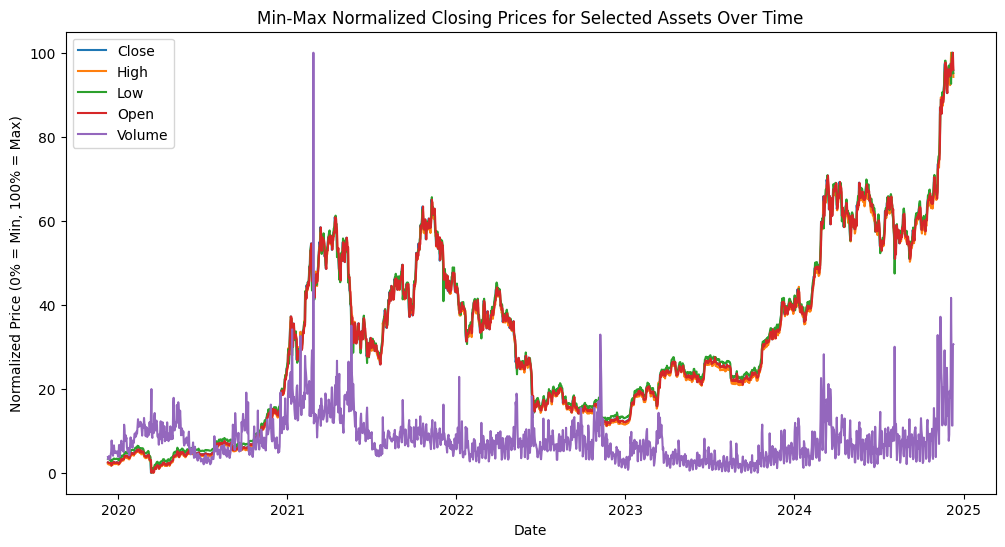

                          Date           Open           High           Low  \
0    2019-12-10 00:00:00+00:00    7397.134277    7424.022949   7246.043945   
1    2019-12-11 00:00:00+00:00    7277.197754    7324.156250   7195.527344   
2    2019-12-12 00:00:00+00:00    7216.738770    7266.639648   7164.741211   
3    2019-12-13 00:00:00+00:00    7244.662109    7293.560547   7227.122559   
4    2019-12-14 00:00:00+00:00    7268.902832    7308.836426   7097.208984   
...                        ...            ...            ...           ...   
1823 2024-12-06 00:00:00+00:00   97074.226562  102039.882812  96514.875000   
1824 2024-12-07 00:00:00+00:00   99916.710938  100563.382812  99030.882812   
1825 2024-12-08 00:00:00+00:00   99921.914062  101399.992188  98771.515625   
1826 2024-12-09 00:00:00+00:00  101237.062500  101272.507812  94355.914062   
1827 2024-12-10 00:00:00+00:00   97391.328125   98220.039062  94435.835938   

              Close        Volume  
0       7278.119629   18249

In [ ]:
if 'Datetime' in btc.columns:
    btc.rename(columns={'Datetime': 'Date'}, inplace=True)
    btc = btc.drop(columns="Volume")

print(btc)

# Perform min-max normalization for each asset
normalized_prices = btc.copy() #closed_prices, crypto_df, non_crypto_df, btc, compiled

# Exclude the 'Date' column during normalization
for col in normalized_prices.columns[1:]:
    min_price = normalized_prices[col].min()
    max_price = normalized_prices[col].max()
    normalized_prices[col] = ((normalized_prices[col] - min_price) / (max_price - min_price)) * 100

# Melt the DataFrame to long format
normalized_prices_melted = normalized_prices.melt(id_vars='Date', var_name='Asset', value_name='Normalized Price')

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each asset's normalized prices
for asset, data in normalized_prices_melted.groupby('Asset'):
    ax.plot(data['Date'], data['Normalized Price'], label=asset)

# Set labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Normalized Price (0% = Min, 100% = Max)')
ax.set_title('Min-Max Normalized Closing Prices for Selected Assets Over Time')
ax.legend()

# Show the plot
plt.show()

print(btc)

In [3]:
import pandas as pd
import os

def clean_sentiment_score(score):
    """Remove leading single quote from sentiment score if present"""
    if isinstance(score, str) and score.startswith("'"):
        return float(score.lstrip("'"))
    return float(score)

# Read the sentiment file
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'combined_crypto_analysis.csv')
sentiment_df = pd.read_csv(file_path)

# Process and merge the data
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date']).dt.tz_localize('UTC')
sentiment_df['sentiment_score'] = sentiment_df['avg_sentiment'].apply(clean_sentiment_score)
btc['Date'] = pd.to_datetime(btc['Date'])

# Merge and update btc DataFrame
btc = btc.merge(sentiment_df[['Date', 'sentiment_score']], on='Date', how='left')

print(f"Merged shape: {btc.shape}, Rows with sentiment: {btc['sentiment_score'].notna().sum()}")

Merged shape: (1828, 7), Rows with sentiment: 1819


btc
              Open          High           Low     Close       Volume  \
0      7277.197754   7324.156250   7195.527344 -0.833902  16350490689   
1      7216.738770   7266.639648   7164.741211  0.356180  18927080224   
2      7244.662109   7293.560547   7227.122559  0.366558  17125736940   
3      7268.902832   7308.836426   7097.208984 -1.994732  17137029730   
4      7124.239746   7181.075684   6924.375977  0.387778  16881129804   
...            ...           ...           ...       ...          ...   
1813  91978.140625  97361.179688  91778.664062  4.323745  71133452438   
1814  95954.945312  96650.203125  94677.351562 -0.323108  52260008261   
1815  95653.953125  98693.171875  95407.882812  1.891279  54968682476   
1816  97468.812500  97499.343750  96144.218750 -1.038839  31634227866   
1817  96461.335938  97888.125000  95770.187500  0.861319  36590695296   

      sentiment_score    Close_True  
0           -3.091240   7217.427246  
1           -1.256544   7243.134277  
2    

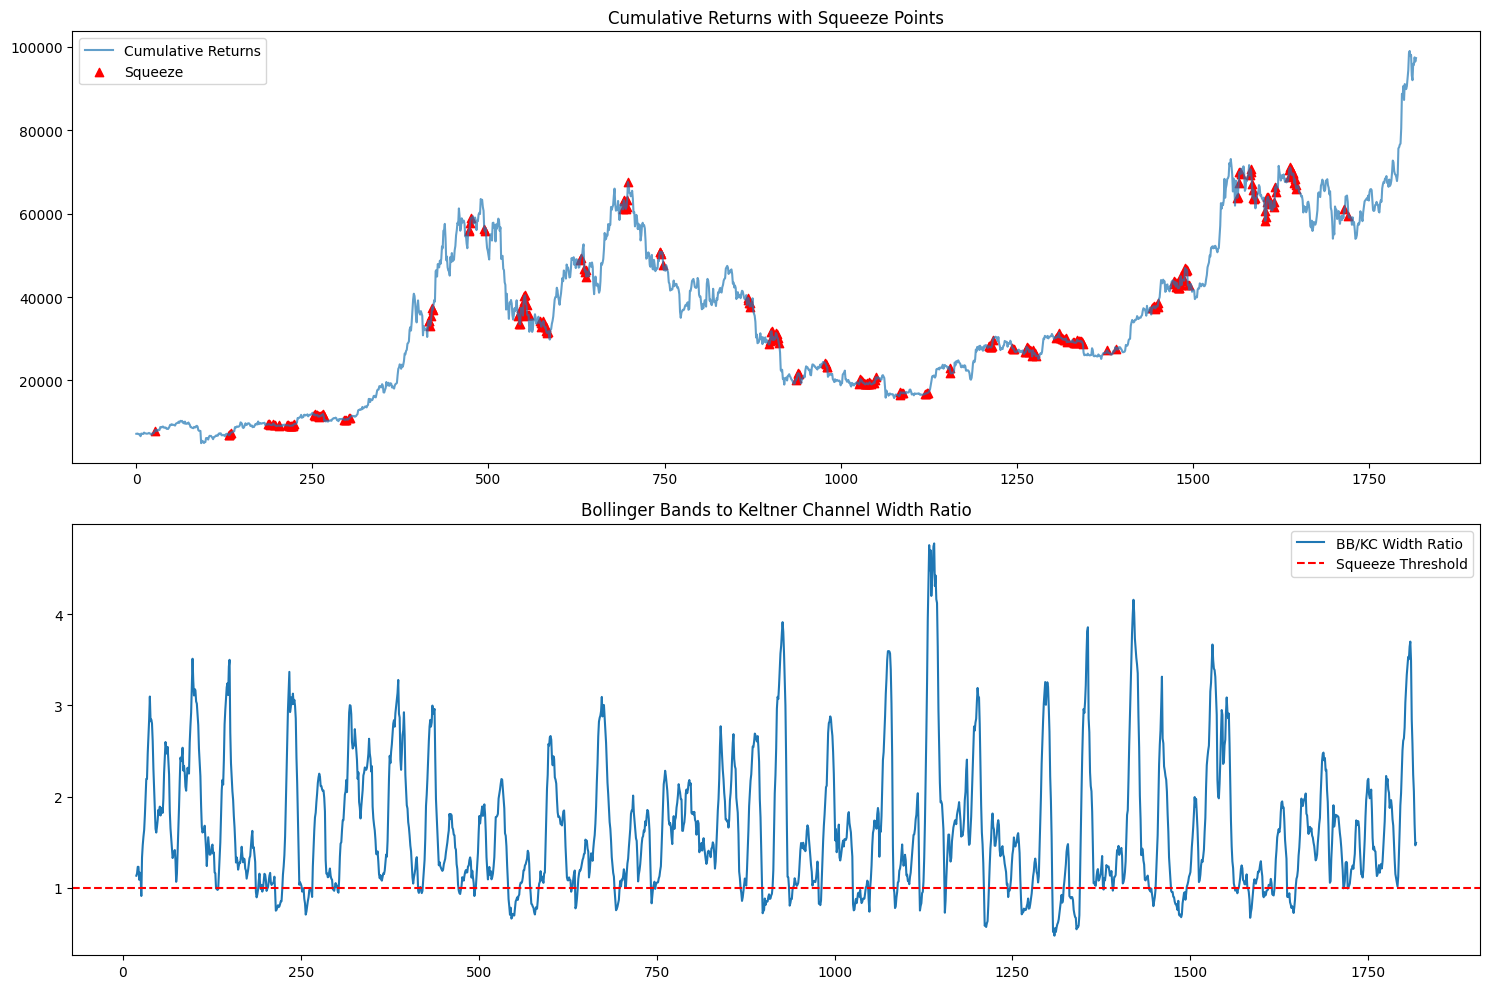

count     1799.000000
mean      7619.597131
std       6274.041902
min        362.584866
25%       2661.682418
50%       6321.342531
75%      10872.497020
max      39268.288731
Name: BB_width, dtype: float64
count     1799.000000
mean      4697.205000
std       3280.629436
min        425.924936
25%       1891.612121
50%       3959.693336
75%       7106.709501
max      16079.761631
Name: KC_width, dtype: float64
count    1799.000000
mean        1.652803
std         0.737230
min         0.473087
25%         1.094195
50%         1.455048
75%         2.032439
max         4.776663
Name: BB_KC_ratio, dtype: float64
First few values of cumulative_returns:
1813    95962.531250
1814    95652.468750
1815    97461.523438
1816    96449.054688
1817    97279.789062
Name: Close_True, dtype: float64
First few values of cumulative_high:
1813    97361.179688
1814    96650.203125
1815    98693.171875
1816    97499.343750
1817    97888.125000
Name: High, dtype: float64
First few values of cumulative_low:
1

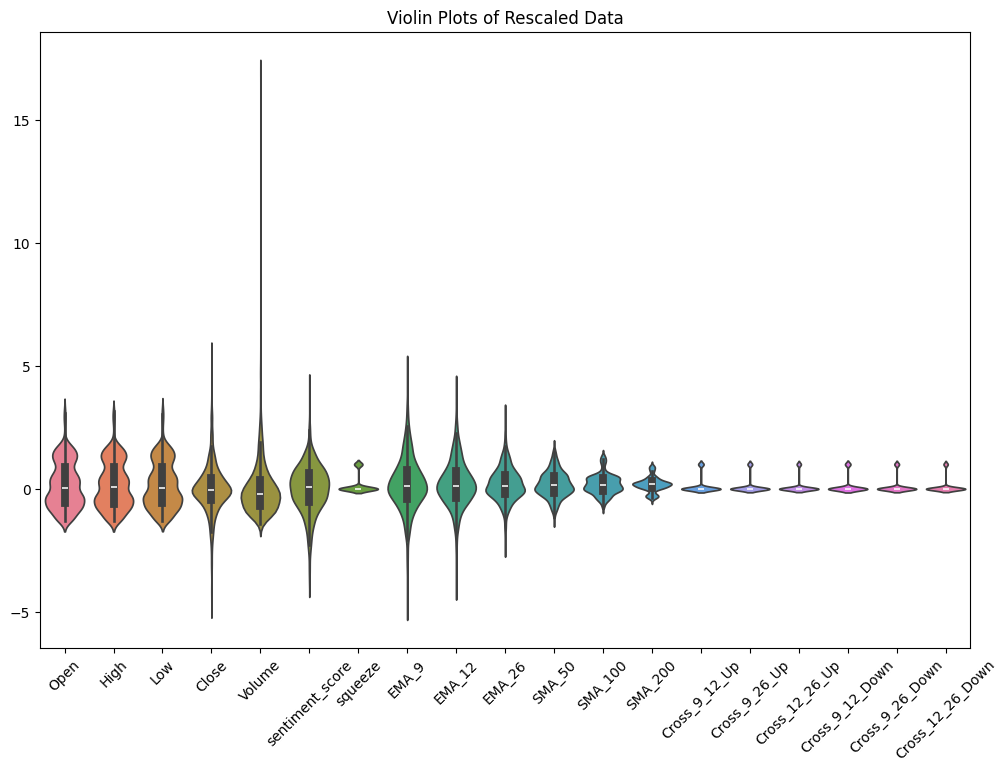

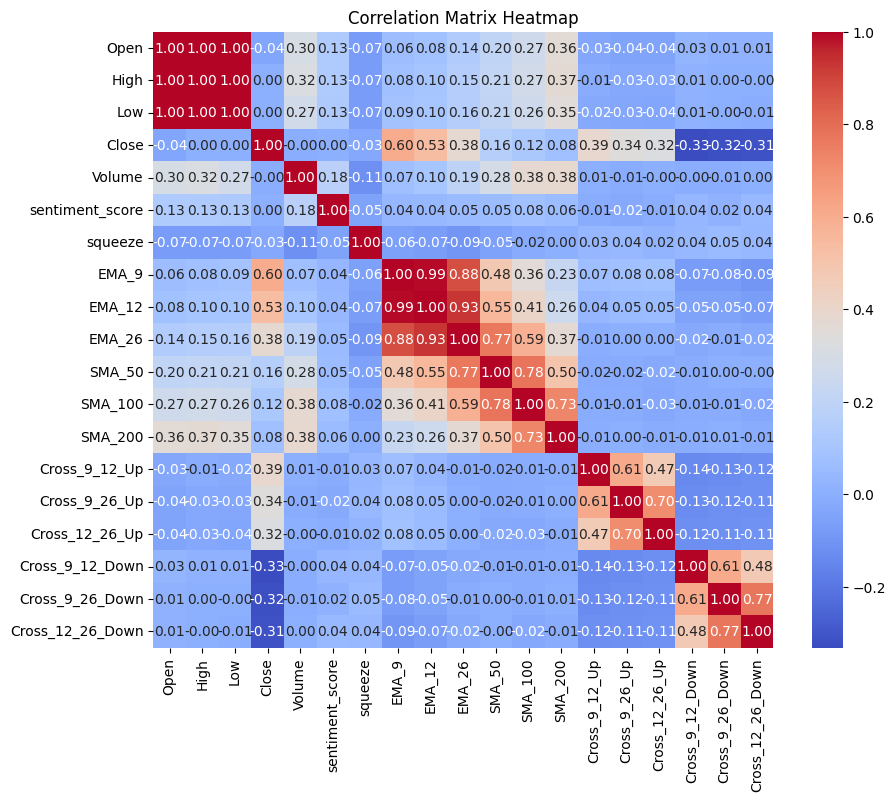

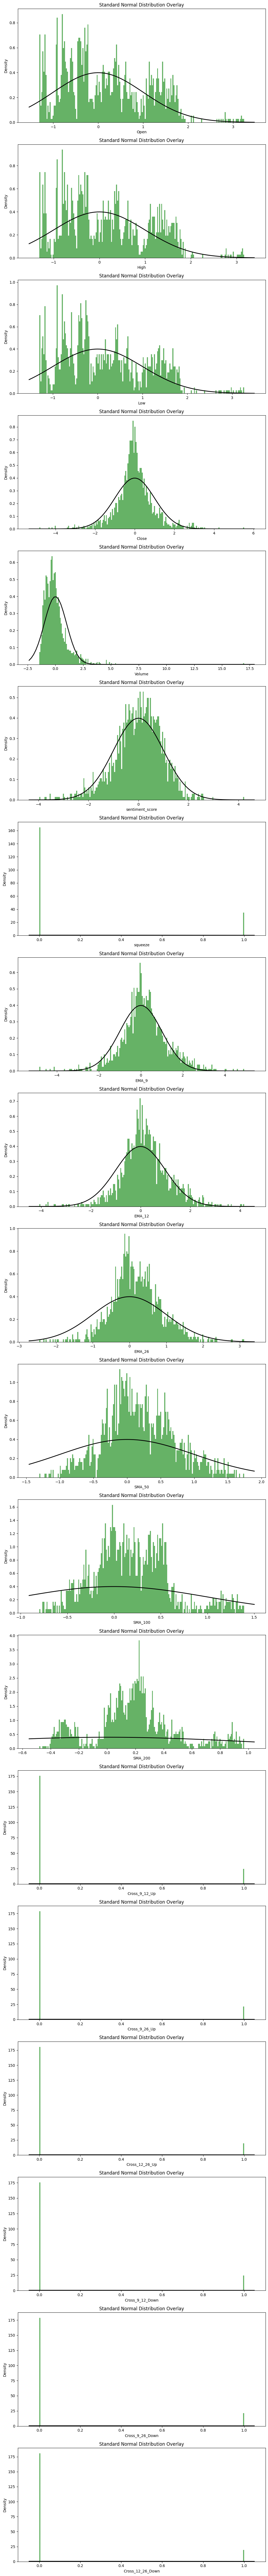

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Converts Close to Percentage ################################################################################
btc["Close_True"] = btc['Close']
btc['Close'] = btc['Close'].pct_change() * 100
btc = btc.dropna().reset_index(drop=True)

def global_rescale(data):
    mean_val = np.mean(data)
    std_val = np.std(data)
    if std_val == 0:
        rescaled_data = np.zeros_like(data)
    else:
        rescaled_data = (data - mean_val) / std_val
    return rescaled_data

if 'Date' in btc.columns:
    btc = btc.drop(columns='Date')
# Apply the global_rescale function to each column
rescaled_data = btc.apply(global_rescale)
print("btc")
print(btc)
print("rescaled_data")
print(rescaled_data)

# Calculate EMA for ATR
def calculate_ema(series, length):
    return series.ewm(span=length, adjust=False).mean()

# Parameters
bb_length = 20
bb_std_dev = 2
kc_length = 20
kc_multiplier = 1.5

# Convert percentage changes back to price-like series for calculations
cumulative_returns = btc['Close_True']
cumulative_high = btc['High']
cumulative_low = btc['Low']

# Calculate Bollinger Bands on the cumulative series
sma = cumulative_returns.rolling(window=bb_length).mean()
std = cumulative_returns.rolling(window=bb_length).std()
bb_upper = sma + (bb_std_dev * std)
bb_lower = sma - (bb_std_dev * std)

# Calculate True Range using cumulative values
tr1 = cumulative_high - cumulative_low
tr2 = abs(cumulative_high - cumulative_returns.shift(1))
tr3 = abs(cumulative_low - cumulative_returns.shift(1))
true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

# Calculate ATR using EMA
atr = calculate_ema(true_range, kc_length)

# Calculate Keltner Channels
kc_upper = sma + (kc_multiplier * atr)
kc_lower = sma - (kc_multiplier * atr)

# Calculate TTM Squeeze
squeeze = np.where(
    (bb_upper < kc_upper) & (bb_lower > kc_lower),
    1,  # Squeeze is on
    0   # Squeeze is off
)

# Calculate Momentum
highest_high = cumulative_high.rolling(window=bb_length).max()
lowest_low = cumulative_low.rolling(window=bb_length).min()
avg_hl = (highest_high + lowest_low) / 2
avg_hlc = (avg_hl + cumulative_returns) / 2
momentum = cumulative_returns - avg_hlc

# Store calculations
btc['squeeze'] = squeeze
rescaled_data['squeeze'] = squeeze
btc['momentum'] = momentum
btc['BB_upper'] = bb_upper
btc['BB_lower'] = bb_lower
btc['KC_upper'] = kc_upper
btc['KC_lower'] = kc_lower
btc['BB_width'] = bb_upper - bb_lower
btc['KC_width'] = kc_upper - kc_lower
btc['BB_KC_ratio'] = (bb_upper - bb_lower) / (kc_upper - kc_lower)

# Print statistics
print("\nBand Width Statistics:")
print("\nBollinger Band Width:")
print(btc['BB_width'].describe())
print("\nKeltner Channel Width:")
print(btc['KC_width'].describe())
print("\nSqueeze Statistics:")
print(f"Total periods: {len(btc)}")
print(f"Number of squeeze periods: {btc['squeeze'].sum()}")
print(f"Percentage of time in squeeze: {(btc['squeeze'].sum() / len(btc) * 100):.2f}%")

# Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Price with squeeze points
plt.subplot(2, 1, 1)
plt.plot(btc.index, cumulative_returns, label='Cumulative Returns', alpha=0.7)
squeeze_points = btc[btc['squeeze'] == 1].index
plt.scatter(squeeze_points,
           cumulative_returns[squeeze_points],
           color='red', marker='^', label='Squeeze')
plt.title('Cumulative Returns with Squeeze Points')
plt.legend()

# Plot 2: BB/KC Width Ratio
plt.subplot(2, 1, 2)
plt.plot(btc.index, btc['BB_KC_ratio'], label='BB/KC Width Ratio')
plt.axhline(y=1, color='r', linestyle='--', label='Squeeze Threshold')
plt.title('Bollinger Bands to Keltner Channel Width Ratio')
plt.legend()

plt.tight_layout()
plt.show()

print(btc['BB_width'].describe())
print(btc['KC_width'].describe())
print(btc['BB_KC_ratio'].describe())

# Print initial values to check scales and consistency
print("First few values of cumulative_returns:")
print(cumulative_returns.tail())

print("First few values of cumulative_high:")
print(cumulative_high.tail())

print("First few values of cumulative_low:")
print(cumulative_low.tail())

# After calculating True Range and ATR
print("\nFirst few values of True Range (TR):")
print(tr1.tail(), tr2.tail(), tr3.tail())

print("\nFirst few values of Average True Range (ATR):")
print(atr.tail())

# After calculating Bollinger Bands
print("\nFirst few values of SMA for Bollinger Bands:")
print(sma.tail())

print("\nFirst few values of Bollinger Bands Upper and Lower:")
print("BB Upper:", bb_upper.tail())
print("BB Lower:", bb_lower.tail())

# After calculating Keltner Channels
print("\nFirst few values of Keltner Channels Upper and Lower:")
print("KC Upper:", kc_upper.tail())
print("KC Lower:", kc_lower.tail())

# After calculating Widths
print("\nBollinger Band Width:")
print(btc['BB_width'].tail())

print("\nKeltner Channel Width:")
print(btc['KC_width'].tail())

# Print ratios and squeeze information
print("\nFirst few values of BB/KC Width Ratio:")
print(btc['BB_KC_ratio'].tail())

print("\nSqueeze Statistics:")
print("First few periods of squeeze signal:")
print(btc['squeeze'].tail())

rescaled_data.drop(columns=['Close_True'], inplace=True)

# Calculate EMAs and SMAs on the raw price data
# (keeping original price-based MAs for cross detection)
price_emas = {
    'EMA_9': btc['Close'].ewm(span=9, adjust=False).mean(),
    'EMA_12': btc['Close'].ewm(span=12, adjust=False).mean(),
    'EMA_26': btc['Close'].ewm(span=26, adjust=False).mean(),
    'SMA_50': btc['Close'].rolling(window=50).mean(),
    'SMA_100': btc['Close'].rolling(window=100).mean(),
    'SMA_200': btc['Close'].rolling(window=200).mean()
}

# Calculate percentage-based EMAs and SMAs
# (these will be your actual features)
rescaled_data['EMA_9'] = btc['Close'].ewm(span=9, adjust=False).mean()
rescaled_data['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean()
rescaled_data['EMA_26'] = btc['Close'].ewm(span=26, adjust=False).mean()
rescaled_data['SMA_50'] = btc['Close'].rolling(window=50).mean()
rescaled_data['SMA_100'] = btc['Close'].rolling(window=100).mean()
rescaled_data['SMA_200'] = btc['Close'].rolling(window=200).mean()

# Detect upward crossovers
rescaled_data['Cross_9_12_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Up'] = ((rescaled_data['EMA_9'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Up'] = ((rescaled_data['EMA_12'] > rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) <= rescaled_data['EMA_26'].shift(1))).astype(int)

# Detect downward crossovers
rescaled_data['Cross_9_12_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_12']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_12'].shift(1))).astype(int)
rescaled_data['Cross_9_26_Down'] = ((rescaled_data['EMA_9'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_9'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)
rescaled_data['Cross_12_26_Down'] = ((rescaled_data['EMA_12'] < rescaled_data['EMA_26']) & (rescaled_data['EMA_12'].shift(1) >= rescaled_data['EMA_26'].shift(1))).astype(int)

# Drop all NaN values and reset index
rescaled_data.dropna(inplace=True)
rescaled_data.reset_index(drop=True, inplace=True)

print("Rescaled Data:")
print(rescaled_data)

#rescaled_data = rescaled_data.drop(columns=['Date'])

# Compute basic statistics for each column
stats = rescaled_data.describe()

# Print the statistics
print("\nBasic Statistical Summary:")
print(stats)

# Plot violin plots for each column
plt.figure(figsize=(12, 8))
sns.violinplot(data=rescaled_data)
plt.title('Violin Plots of Rescaled Data')
plt.xticks(rotation=45)
plt.show()

# Compute the correlation matrix
corr_matrix = rescaled_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Plot histograms with a standard normal distribution overlay for each column
fig, axes = plt.subplots(nrows=len(rescaled_data.columns), ncols=1, figsize=(10, 5 * len(rescaled_data.columns)))
if len(rescaled_data.columns) == 1:
    axes = [axes]  # Ensure axes is iterable for a single-column dataframe

for ax, column in zip(axes, rescaled_data.columns):
    data = rescaled_data[column].dropna()  # Drop NA values

    bins = 200

    # Plot histogram
    ax.hist(data, bins=bins, density=True, alpha=0.6, color='g')

    # Define the range of x values for the normal distribution line
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)

    # Calculate the standard normal distribution
    p = norm.pdf(x, 0, 1)  # Mean = 0, Std = 1
    ax.plot(x, p, 'k', linewidth=2)

    ax.set_title(f"Standard Normal Distribution Overlay")
    ax.set_xlabel(column)
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
import warnings
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
import pandas as pd
from torch import nn
from skorch import NeuralNetRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt
from skorch.callbacks import EarlyStopping, LRScheduler
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.dataset import Dataset
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import ks_2samp
from tqdm import tqdm
import time
from skorch.callbacks import Callback
import torch.nn.functional as F

class ProgressCallback(Callback):
    def __init__(self, total_epochs, desc="Training"):
        self.pbar = None
        self.total_epochs = total_epochs
        self.desc = desc

    def on_train_begin(self, net, X=None, y=None, **kwargs):
        # Close any existing progress bar
        if self.pbar is not None:
            self.pbar.close()
        self.pbar = tqdm(total=self.total_epochs, desc=self.desc, leave=False)

    def on_epoch_end(self, net, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)

    def on_train_end(self, net, X=None, y=None, **kwargs):
        if self.pbar is not None:
            self.pbar.close()
            self.pbar = None

class PrintLossCallback(Callback):
    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        train_loss = net.history[-1, 'train_loss']
        valid_loss = net.history[-1, 'valid_loss']
        epoch = len(net.history)
        print(f'Epoch: {epoch:4d} | Train Loss: {train_loss:.6f} | Valid Loss: {valid_loss:.6f}')

class NoSmallLoss(nn.Module):
    def __init__(self, lower_bound=-0.5, upper_bound=0.5, penalty_weight=1.0):
        super().__init__()
        self.base_criterion = nn.MSELoss()
        self.penalty_weight = penalty_weight
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.last_base_loss = 0
        self.last_penalty = 0

    def forward(self, pred, target):
        # Calculate base MSE loss
        base_loss = self.base_criterion(pred, target)

        # Create mask for targets outside the bounds
        target_outside_bounds = (target < self.lower_bound) | (target > self.upper_bound)
        pred_in_bounds = (pred > self.lower_bound) & (pred < self.upper_bound)
        should_penalize = target_outside_bounds & pred_in_bounds

        # Calculate the appropriate penalty based on target direction
        penalty = torch.where(
            target > self.upper_bound,
            F.relu(self.upper_bound - pred) * should_penalize.float(), 
            torch.where(
                target < self.lower_bound,
                F.relu(pred - self.lower_bound) * should_penalize.float(),  
                torch.zeros_like(pred) 
            )
        )

        # Apply penalty and normalize by batch size
        penalty = (penalty ** 2).mean() * self.penalty_weight

        total_loss = base_loss + penalty

        # Store components for monitoring
        with torch.no_grad():
            self.last_base_loss = base_loss.item()
            self.last_penalty = penalty.item()
            small_pred_ratio = torch.sum(pred_in_bounds.float()) / pred.numel()
            penalty_ratio = penalty / (base_loss + 1e-8)
            target_in_bounds_ratio = torch.sum((~target_outside_bounds).float()) / target.numel()
            self.small_pred_ratio = small_pred_ratio
            self.penalty_ratio = penalty_ratio
            self.target_in_bounds_ratio = target_in_bounds_ratio

        return total_loss

class TrialPruningCallback(Callback):
    def __init__(self, threshold_loss=30000.0, min_epochs=10, max_bad_epochs=5):
        self.threshold_loss = threshold_loss
        self.min_epochs = min_epochs
        self.max_bad_epochs = max_bad_epochs
        self.bad_epochs = 0

    def on_epoch_end(self, net, dataset_train=None, dataset_valid=None, **kwargs):
        epoch = len(net.history)
        # Get the valid_loss which is NoSmallLoss output (MSE + penalty)
        current_loss = net.history[-1, 'valid_loss']

        # Only start checking after min_epochs
        if epoch >= self.min_epochs:
            if current_loss > self.threshold_loss:
                self.bad_epochs += 1
                print(f"\nWarning: Loss {current_loss:.2f} above threshold {self.threshold_loss:.2f}. "
                      f"Bad epochs: {self.bad_epochs}/{self.max_bad_epochs}")
            else:
                self.bad_epochs = 0

            if self.bad_epochs >= self.max_bad_epochs:
                print(f"\nPruning trial - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")
                raise KeyboardInterrupt(f"Trial pruned - Loss above {self.threshold_loss:.2f} for {self.max_bad_epochs} epochs")

# 1. Data Splitting Configuration
test_size = 0.2
val_size = 0.2
eval_size = 0.1

def prepare_train_test_splits(data, target_col):
    """Prepare train, validation, eval, and test splits while maintaining temporal order"""
    total_size = len(data)
    test_split_idx = int(total_size * (1 - test_size))
    val_split_idx = int(test_split_idx * (1 - val_size - eval_size))
    eval_split_idx = int(test_split_idx * (1 - eval_size))

    splits = {
        'train': {
            'X': data.iloc[:val_split_idx, :],
            'y': data[target_col][:val_split_idx]
        },
        'eval': {
            'X': data.iloc[val_split_idx:eval_split_idx, :],
            'y': data[target_col][val_split_idx:eval_split_idx]
        },
        'val': {
            'X': data.iloc[eval_split_idx:test_split_idx, :],
            'y': data[target_col][eval_split_idx:test_split_idx]
        },
        'test': {
            'X': data.iloc[test_split_idx:, :],
            'y': data[target_col][test_split_idx:]
        }
    }
    return splits

def evaluate_model_with_distribution(model, X_test_seq, y_test_seq, train_distribution, history=None):
    """Enhanced model evaluation including distribution comparison"""
    # Get predictions
    y_pred_test = model.predict(X_test_seq)

    # Calculate metrics
    test_mse = mean_squared_error(y_test_seq, y_pred_test)
    test_r2 = r2_score(y_test_seq, y_pred_test)

    # Flatten arrays before KS test
    train_dist_flat = train_distribution.flatten()
    pred_dist_flat = y_pred_test.flatten()

    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = ks_2samp(train_dist_flat, pred_dist_flat)

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))

    # Prediction scatter plot
    axes[0,0].scatter(y_test_seq, y_pred_test, alpha=0.5)
    axes[0,0].plot([y_test_seq.min(), y_test_seq.max()],
                   [y_test_seq.min(), y_test_seq.max()],
                   'k--', lw=3)
    axes[0,0].set_title('Predicted vs. True Values')
    axes[0,0].set_xlabel('True Values')
    axes[0,0].set_ylabel('Predicted Values')
    axes[0,0].grid(True)

    # Distribution comparison
    axes[0,1].hist(train_dist_flat, bins=50, alpha=0.5, density=True, label='Training')
    axes[0,1].hist(pred_dist_flat, bins=50, alpha=0.5, density=True, label='Predictions')
    axes[0,1].set_title(f'Distribution Comparison\nKS test: stat={ks_statistic:.3f}, p={p_value:.3f}')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Learning curves
    if history:
        train_loss = [h['train_loss'] for h in history]
        valid_loss = [h['valid_loss'] for h in history if 'valid_loss' in h]

        axes[1,0].plot(train_loss, label='Training Loss', marker='o')
        axes[1,0].plot(valid_loss, label='Validation Loss', marker='o')
        axes[1,0].set_title('Loss over Epochs')
        axes[1,0].set_xlabel('Epochs')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True)

    # QQ plot
    from scipy.stats import probplot
    probplot(pred_dist_flat, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot of Predictions')

    plt.tight_layout()
    plt.show()

    return {
        'test_mse': test_mse,
        'test_r2': test_r2,
        'ks_statistic': ks_statistic,
        'ks_pvalue': p_value
    }

# Initial data preparation
splits = prepare_train_test_splits(rescaled_data, 'Close')
X_train, y_train = splits['train']['X'], splits['train']['y']
X_eval, y_eval = splits['eval']['X'], splits['eval']['y']
X_val, y_val = splits['val']['X'], splits['val']['y']
X_test, y_test = splits['test']['X'], splits['test']['y']

class ImprovedLSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2, nonlin=nn.ReLU(),
                 dropout_rate=0.1, use_residual=True):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate if num_layers > 1 else 0
        )

        lstm_output_dim = hidden_size * 2
        self.layer_norm = nn.LayerNorm(lstm_output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(lstm_output_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.use_residual = use_residual
        self.nonlin = nonlin

    def forward(self, X):
        lstm_out, _ = self.lstm(X)
        out = lstm_out[:, -1, :]

        out = self.layer_norm(out)
        identity = self.fc1(out)
        out = self.fc1(out)
        out = self.nonlin(out)
        out = self.dropout(out)

        if self.use_residual:
            out = out + identity

        out = self.fc2(out)
        return out

def create_sequences(data, target, seq_length):
    """Create sequences for LSTM processing"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].to_numpy())
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

def prepare_data(data, target, seq_length):
    """Prepare data with specific sequence length"""
    X_seq, y_seq = create_sequences(data, target, seq_length)
    return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32).reshape(-1, 1)

space = {
    'seq_length': hp.choice('seq_length', [10,20,30.50,100]), #5, 10, 15, 20, 30, 50
    'hidden_size': hp.choice('hidden_size', [64, 128,256,512]),
    'num_layers': hp.choice('num_layers', [1,2,3,4,5]),
    'dropout_rate': hp.uniform('dropout_rate', 0.05, 0.4),
    'nonlin': hp.choice('nonlin', [nn.ReLU(), nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()]), #, nn.Tanh(), nn.LeakyReLU(negative_slope=0.1), nn.GELU()
    'max_epochs': hp.choice('max_epochs', [500]),
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.1)), #np.log(0.0001), np.log(0.1))
    'batch_size': hp.choice('batch_size', [64,128]),
    'weight_decay': hp.uniform('weight_decay', 0.001, 0.4), # hp.uniform('weight_decay', 0.001, 0.05
    'use_residual': hp.choice('use_residual', [True]),
    'loss_lower_bound': hp.uniform('loss_lower_bound', -2, -1),  # Customize range as needed
    'loss_upper_bound': hp.uniform('loss_upper_bound', 1, 2),    # Customize range as needed
    'loss_penalty_weight': hp.uniform('loss_penalty_weight', 10, 100000)
}

def objective(params):
    """Modified objective function with better error handling for valid_loss"""
    try:
        # Calculate threshold with safer history access
        threshold_loss = 30000.0  # Default threshold
        if len(trials.trials) > 0:
            valid_losses = []
            for trial in trials.trials:
                # Safely access trial history
                try:
                    if ('result' in trial and
                        'model' in trial['result'] and
                        trial['result']['model'] is not None and
                        hasattr(trial['result']['model'], 'history_')):  # Note the history_ attribute

                        # Get valid losses from history, safely handling missing keys
                        trial_losses = [h.get('valid_loss', float('inf'))
                                      for h in trial['result']['model'].history_
                                      if isinstance(h, dict)]

                        if trial_losses:
                            valid_losses.append(min(trial_losses))
                except (KeyError, AttributeError):
                    continue

            if valid_losses:
                best_loss_so_far = min(valid_losses)
                threshold_loss = min(100.0 * best_loss_so_far, 30000.0)

        start_time = time.time()
        print(f"\nStarting new trial with parameters:")
        for key, value in params.items():
            if isinstance(value, (nn.Module)):
                print(f"{key}: {value.__class__.__name__}")
            else:
                print(f"{key}: {value}")

        seq_length = int(params['seq_length'])

        # Prepare data
        X_train_seq, y_train_seq = prepare_data(X_train, y_train, seq_length)
        X_eval_seq, y_eval_seq = prepare_data(X_eval, y_eval, seq_length)

        X_combined = torch.cat([X_train_seq, X_eval_seq])
        y_combined = torch.cat([y_train_seq, y_eval_seq])

        train_distribution = y_train_seq.numpy().flatten()

        callbacks = [
            ('print_loss', PrintLossCallback()),
            ('trial_pruning', TrialPruningCallback(
                threshold_loss=threshold_loss,
                min_epochs=20,
                max_bad_epochs=15
            )),
            ('lr_scheduler', LRScheduler(
                policy=ReduceLROnPlateau,
                monitor='valid_loss',
                mode='min',
                patience=35,
                factor=0.5,
                verbose=True
            )),
            ('early_stopping', EarlyStopping(
                monitor='valid_loss',
                patience=115,
                threshold=0.0001,
                threshold_mode='rel',
                lower_is_better=True
            )),
            #('progress', ProgressCallback(params['max_epochs']))
        ]

        # Create and train the model
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=DeprecationWarning)

            net = NeuralNetRegressor(
                ImprovedLSTMModule,
                module__input_size=X_combined.shape[2],
                module__hidden_size=int(params['hidden_size']),
                module__num_layers=int(params['num_layers']),
                module__dropout_rate=params['dropout_rate'],
                module__nonlin=params['nonlin'],
                module__use_residual=params['use_residual'],
                max_epochs=int(params['max_epochs']),
                lr=params['lr'],
                batch_size=int(params['batch_size']),
                optimizer=torch.optim.Adam,
                optimizer__weight_decay=params['weight_decay'],
                criterion=NoSmallLoss,
                criterion__lower_bound=params.get('loss_lower_bound', -0.5),
                criterion__upper_bound=params.get('loss_upper_bound', 0.5),
                criterion__penalty_weight=params.get('loss_penalty_weight', 100.0),
                callbacks=callbacks,
                verbose=0
            )

            try:
                net.fit(X_combined, y_combined)
                was_pruned = False
            except KeyboardInterrupt as e:
                if "Trial pruned" in str(e):
                    print("\nTrial pruned due to high loss")
                    return {
                        'loss': float('inf'),
                        'status': STATUS_OK,
                        'val_score': float('inf'),
                        'time': time.time() - start_time,
                        'params': params
                    }
                else:
                    raise e
            except Exception as e:
                print(f"\nError during training: {str(e)}")
                return {
                    'loss': float('inf'),
                    'status': STATUS_OK,
                    'model': None,
                    'params': params
                }

        # Calculate validation loss
        try:
            X_val_seq, y_val_seq = prepare_data(X_val, y_val, seq_length)
            val_pred = net.predict(X_val_seq)
            val_mse = mean_squared_error(y_val_seq, val_pred)
        except Exception as e:
            print(f"\nError during validation: {str(e)}")
            return {
                'loss': float('inf'),
                'status': STATUS_OK,
                'model': None,
                'params': params
            }

        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f} seconds")
        print(f"Validation MSE: {val_mse:.4f}")

        return {
            'loss': val_mse,
            'status': STATUS_OK,
            'model': net,
            'val_score': val_mse,
            'time': total_time,
            'params': params
        }

    except Exception as e:
        print(f"\nUnexpected error during trial: {str(e)}")
        return {
            'loss': float('inf'),
            'status': STATUS_OK,
            'model': None,
            'params': params
        }


# Run optimization
print("\nStarting optimization")
trials = Trials()
start_time = time.time()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=120,
    trials=trials,
    show_progressbar=True
)

total_time = time.time() - start_time

# Get best trial
best_trial = trials.trials[0]  # Since we're only doing one trial
best_model = best_trial['result']['model']
best_params = best_trial['result']['params']

# Print results
print("\n" + "="*50)
print("Training Results:")
print("="*50)
print(f"Validation MSE: {best_trial['result']['val_score']:.4f}")
print(f"Total training time: {best_trial['result']['time']:.2f} seconds")

print("\nParameters used:")
for param, value in best_params.items():
    if isinstance(value, (nn.Module)):
        print(f"{param}: {value.__class__.__name__}")
    else:
        print(f"{param}: {value}")

# Evaluate on test set
print("\nEvaluating on test set...")
seq_length = int(best_params['seq_length'])
X_test_seq, y_test_seq = prepare_data(X_test, y_test, seq_length)
train_distribution = y_train.values


Starting optimization
                                                       
Starting new trial with parameters:
batch_size: 64                                         
dropout_rate: 0.19915390538493605                      
hidden_size: 64                                        
loss_lower_bound: -1.0223978262889797                  
loss_penalty_weight: 76352.20898531105                 
loss_upper_bound: 1.5526450990610343                   
lr: 0.010089589379814069                               
max_epochs: 500                                        
nonlin: Tanh                                           
num_layers: 1                                          
seq_length: 20                                         
use_residual: True                                     
weight_decay: 0.15875642686714092                      
  0%|          | 0/120 [00:00<?, ?trial/s, best loss=?]

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch:    1 | Train Loss: 4135.498255 | Valid Loss: 1025.861574
Epoch:    2 | Train Loss: 1360.737285 | Valid Loss: 1825.976575
Epoch:    3 | Train Loss: 383.343740 | Valid Loss: 317.986180
Epoch:    4 | Train Loss: 342.895931 | Valid Loss: 2379.032781
Epoch:    5 | Train Loss: 223.703079 | Valid Loss: 1370.392340
Epoch:    6 | Train Loss: 129.298786 | Valid Loss: 784.565450
Epoch:    7 | Train Loss: 71.500656 | Valid Loss: 1694.719506
Epoch:    8 | Train Loss: 875.060228 | Valid Loss: 8142.281938
Epoch:    9 | Train Loss: 1879.059261 | Valid Loss: 665.120621
Epoch:   10 | Train Loss: 622.627849 | Valid Loss: 231.173668
Epoch:   11 | Train Loss: 876.422594 | Valid Loss: 2926.501398
Epoch:   12 | Train Loss: 2038.008742 | Valid Loss: 715.287965
Epoch:   13 | Train Loss: 1514.848195 | Valid Loss: 874.069900
Epoch:   14 | Train Loss: 1310.050932 | Valid Loss: 2033.430079
Epoch:   15 | Train Loss: 810.375422 | Valid Loss: 717.578337
Epoch:   16 | Train Loss: 889.343795 | Valid Loss: 170.62

c:\Users\kghor\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



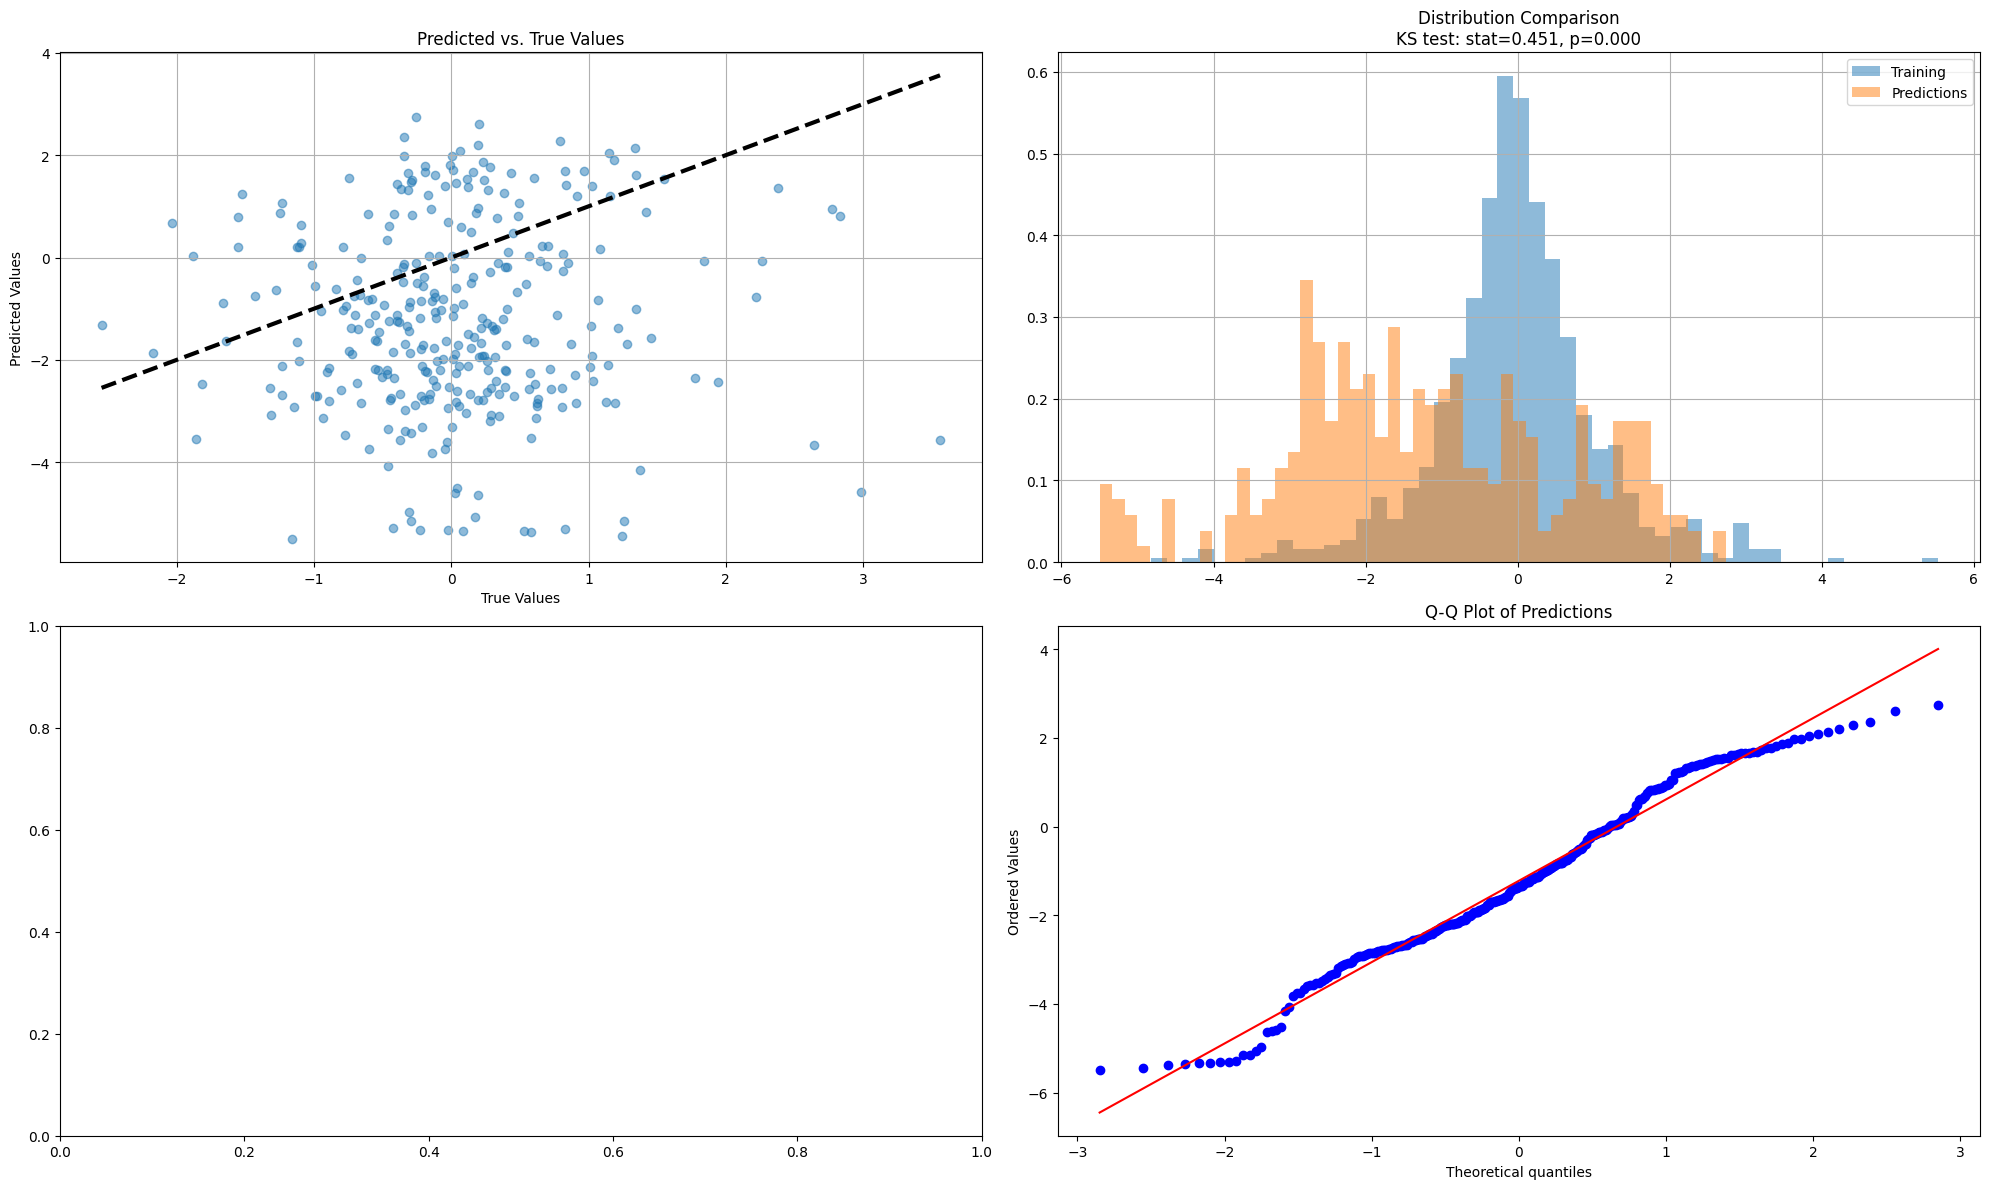

In [ ]:
results = evaluate_model_with_distribution(
    best_model,
    X_test_seq,
    y_test_seq,
    train_distribution,
    None
)


Final Model Evaluation:
Test MSE: 5.5867
Test R2: -6.9968


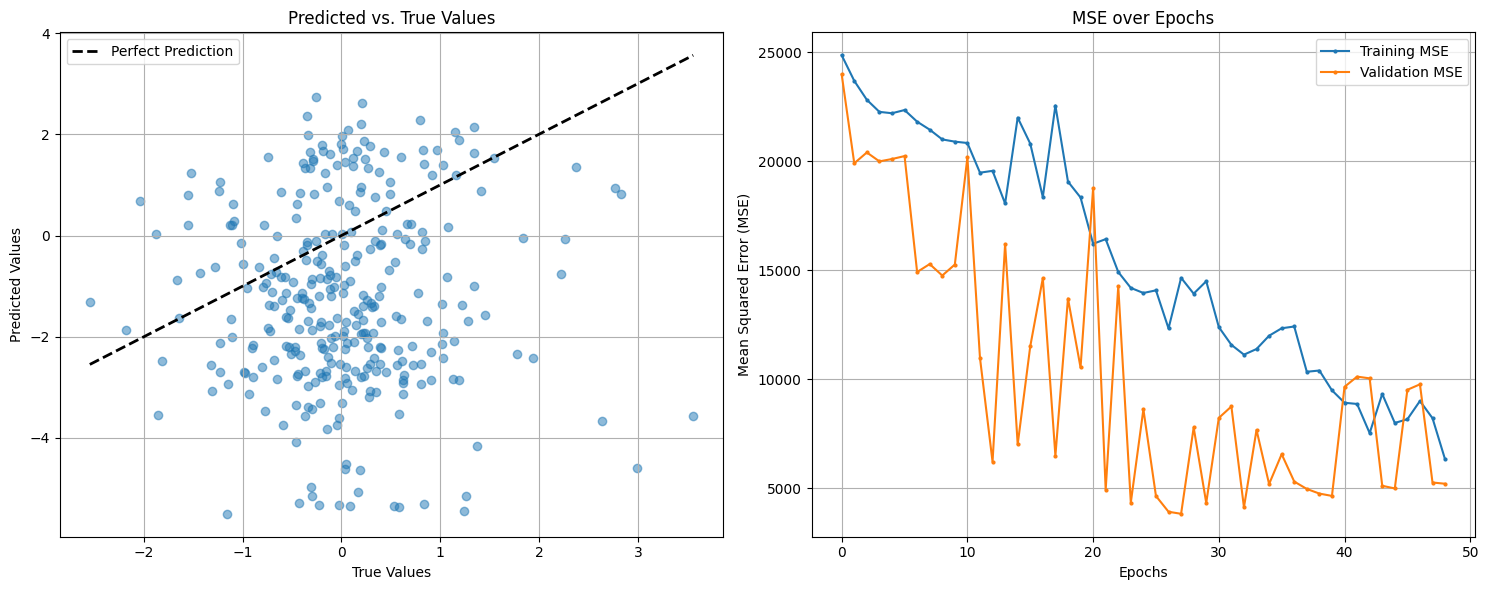


Best Hyperparameters:
batch_size: 64
dropout_rate: 0.06872244586066018
hidden_size: 64
loss_lower_bound: -1.885329972245302
loss_penalty_weight: 86474.34623534794
loss_upper_bound: 1.87789443724279
lr: 0.0002851938030758647
max_epochs: 500
nonlin: ReLU()
num_layers: 3
seq_length: 10
use_residual: True
weight_decay: 0.01040522613175178


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Get the best model and its sequence length
best_model = best_trial['result']['model']
best_seq_length = int(best_trial['result']['params']['seq_length'])

# Prepare test data with best sequence length
X_test_seq, y_test_seq = prepare_data(X_test, y_test, best_seq_length)

# Get predictions on test data
y_pred_test = best_model.predict(X_test_seq)

# Calculate metrics
test_mse = mean_squared_error(y_test_seq, y_pred_test)
test_r2 = r2_score(y_test_seq, y_pred_test)

# Print final results
print("\n" + "="*50)
print("Final Model Evaluation:")
print("="*50)
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

# Convert tensors to numpy if needed
y_pred_test = y_pred_test if isinstance(y_pred_test, np.ndarray) else y_pred_test.detach().numpy()
y_test_seq = y_test_seq if isinstance(y_test_seq, np.ndarray) else y_test_seq.detach().numpy()

# Create visualization plots
plt.figure(figsize=(15, 6))

# 1. Scatter plot of predictions vs actual
plt.subplot(1, 2, 1)
plt.scatter(y_test_seq, y_pred_test, alpha=0.5)
plt.plot([y_test_seq.min(), y_test_seq.max()],
         [y_test_seq.min(), y_test_seq.max()],
         'k--', lw=2,
         label='Perfect Prediction')
plt.title('Predicted vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

# 2. Training and validation loss curves
plt.subplot(1, 2, 2)
history = best_model.history
train_mse = [h['train_loss'] for h in history]
valid_mse = [h['valid_loss'] for h in history if 'valid_loss' in h]

plt.plot(train_mse, label='Training MSE', marker='o', markersize=2)
plt.plot(valid_mse, label='Validation MSE', marker='o', markersize=2)
plt.title('MSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best hyperparameters again for reference
print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for param, value in best_trial['result']['params'].items():
    print(f"{param}: {value}")

# Save the best model
net = best_model

In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def visualize_hyperopt_results(trials):
    """Visualize hyperopt optimization process with MSE values and log scale"""
    # Create evolution of MSE plot with log scale
    losses = [trial['result']['loss'] for trial in trials.trials]  # These are MSE values
    best_losses = np.minimum.accumulate(losses)

    # First plot: MSE evolution over trials
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=losses, name='Trial MSE',
                            mode='markers+lines', marker=dict(size=8)))
    fig.add_trace(go.Scatter(y=best_losses, name='Best MSE',
                            mode='lines', line=dict(width=2)))

    fig.update_layout(
        title='Hyperopt Optimization Progress',
        xaxis_title='Trial Number',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        yaxis_type="log"  # Set y-axis to log scale
    )
    fig.show()

    # Parameter importance visualization
    param_values = {}
    param_scores = {}

    # Collect all parameter values and scores
    for trial in trials.trials:
        for param, value in trial['result']['params'].items():
            if param not in param_values:
                param_values[param] = []
                param_scores[param] = []
            if not isinstance(value, (nn.Module, bool)):  # Skip non-numeric parameters
                param_values[param].append(float(value))
                param_scores[param].append(trial['result']['loss'])

    # Create second plot
    fig = go.Figure()

    for param in param_values.keys():
        if param_values[param]:  # Check if we have values for this parameter
            # Normalize only parameter values to 0-1 range
            param_scaler = MinMaxScaler()
            normalized_param_values = param_scaler.fit_transform(np.array(param_values[param]).reshape(-1, 1)).flatten()

            # Use actual MSE values (not normalized)
            mse_values = np.array(param_scores[param])

            fig.add_trace(go.Scatter(
                x=normalized_param_values,
                y=mse_values,  # Use actual MSE values
                mode='markers',
                name=f"{param}",
                hovertemplate=(
                    f"{param}<br>" +
                    "Normalized Value: %{x:.3f}<br>" +
                    "Original Value: %{customdata[0]:.3f}<br>" +
                    "MSE: %{y:.6f}<br>" +
                    "<extra></extra>"
                ),
                customdata=np.column_stack((
                    param_values[param],
                    mse_values
                ))
            ))

    fig.update_layout(
        title='Parameter Impact on MSE',
        xaxis_title='Normalized Parameter Value (0-1)',
        yaxis_title='MSE (log scale)',
        template='plotly_white',
        xaxis=dict(range=[-0.1, 1.1]),  # Add some padding
        yaxis_type="log"  # Set y-axis to log scale
    )

    # Add vertical reference line at x=0.5
    fig.add_vline(x=0.5, line_dash="dash", line_color="gray", opacity=0.5)

    fig.show()

# Execute the visualization
visualize_hyperopt_results(trials)
#Loog normalize these losses